<a href="https://colab.research.google.com/github/muhammmad-al/decentralized-ai-content-recommender/blob/main/reddit_federated_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
Cloning into 'decentralized-ai-content-recommender'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 15), reused 23 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 1.42 MiB | 3.95 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/decentralized-ai-content-recommender
Setup complete!
Node configuration class defined!
NetworkNode class defined!
NetworkSimulator class defined!


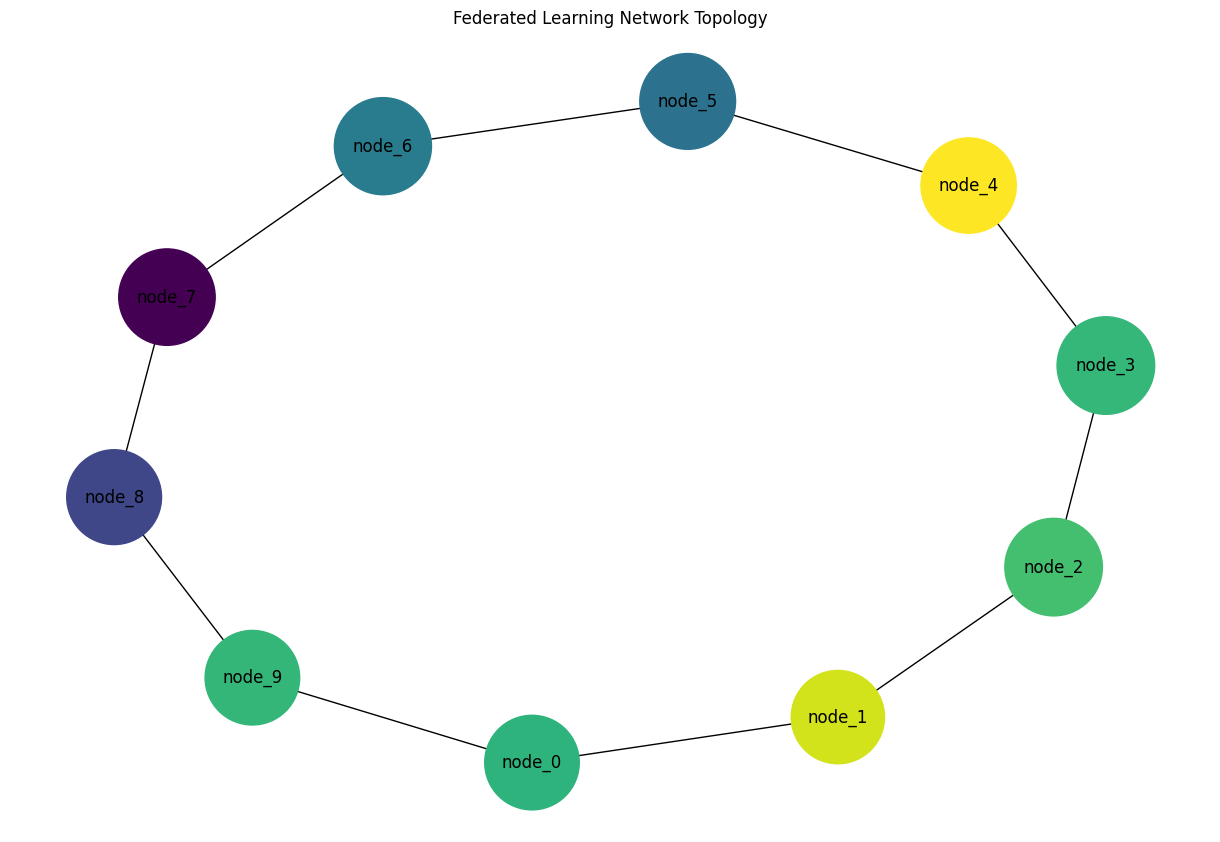

In [12]:
# Cell 1: Initial Setup and Imports
%cd /content
!rm -rf *  # Remove everything first
!git clone https://github.com/muhammmad-al/decentralized-ai-content-recommender.git
%cd decentralized-ai-content-recommender

import os
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Tuple
from dataclasses import dataclass
import asyncio
import random
import time
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)
logger = logging.getLogger(__name__)

print("Setup complete!")

@dataclass
class NodeConfig:
    """Configuration for each network node"""
    node_id: str
    data_path: str
    connection_latency: float = 0.1  # seconds
    connection_reliability: float = 0.95  # 95% reliability
    bandwidth: float = 1.0  # MB/s
    compute_power: float = 1.0  # relative compute power

print("Node configuration class defined!")

class NetworkNode:
    """Simulates a node in the federated learning network"""
    def __init__(self, config: NodeConfig, client: FederatedClient):
        self.config = config
        self.client = client
        self.neighbors = []
        self.message_queue = asyncio.Queue()
        self.is_active = True
        self.metrics = defaultdict(list)

    async def simulate_network_latency(self):
        """Simulate network latency and potential failures"""
        await asyncio.sleep(self.config.connection_latency * random.uniform(0.5, 1.5))
        return random.random() < self.config.connection_reliability

    async def send_message(self, target_node, message_type: str, payload: Any):
        """Send message to another node"""
        success = await self.simulate_network_latency()
        if success:
            await target_node.message_queue.put({
                'source': self.config.node_id,
                'type': message_type,
                'payload': payload,
                'timestamp': time.time()
            })
            logger.info(f"Node {self.config.node_id} sent {message_type} to {target_node.config.node_id}")
        else:
            logger.warning(f"Network failure: {self.config.node_id} -> {target_node.config.node_id}")
            self.metrics['failed_messages'].append(time.time())

    async def process_message(self, message: Dict):
        """Process received message"""
        message_type = message['type']

        if message_type == 'model_update':
            # Process model update from another node
            updated_state = self.client.train(message['payload'])
            self.metrics['training_updates'].append(time.time())
            return updated_state

        elif message_type == 'model_aggregate':
            # Aggregate received models
            self.client.model.load_state_dict(message['payload'])
            metrics = self.client.evaluate()
            self.metrics['aggregation_results'].append(metrics)
            return metrics

    def __repr__(self):
        return f"NetworkNode(id={self.config.node_id}, neighbors={len(self.neighbors)})"

print("NetworkNode class defined!")

class NetworkSimulator:
    """Simulates a network of federated learning nodes"""
    def __init__(self, num_nodes: int = 10):
        self.num_nodes = num_nodes
        self.nodes = []
        self.network_graph = nx.Graph()
        self.executor = ThreadPoolExecutor(max_workers=num_nodes)

    def create_network_topology(self):
        """Create a random network topology"""
        # Create small-world network topology
        base_graph = nx.watts_strogatz_graph(
            n=self.num_nodes,
            k=3,  # Each node connects to 3 nearest neighbors
            p=0.1  # Probability of rewiring
        )

        # Transfer topology to our nodes
        for i, node in enumerate(self.nodes):
            neighbors = list(base_graph.neighbors(i))
            node.neighbors = [self.nodes[n] for n in neighbors]

            # Add to network graph for visualization
            self.network_graph.add_node(
                node.config.node_id,
                compute_power=node.config.compute_power,
                reliability=node.config.connection_reliability
            )

        # Add edges to network graph
        for i, node in enumerate(self.nodes):
            for neighbor in node.neighbors:
                self.network_graph.add_edge(
                    node.config.node_id,
                    neighbor.config.node_id,
                    latency=node.config.connection_latency
                )

    def visualize_network(self):
        """Visualize the network topology"""
        plt.figure(figsize=(12, 8))

        # Node colors based on compute power
        node_colors = [
            self.network_graph.nodes[node]['compute_power']
            for node in self.network_graph.nodes()
        ]

        # Node sizes based on reliability
        node_sizes = [
            5000 * self.network_graph.nodes[node]['reliability']
            for node in self.network_graph.nodes()
        ]

        # Draw network
        pos = nx.spring_layout(self.network_graph)
        nx.draw(
            self.network_graph,
            pos=pos,
            node_color=node_colors,
            node_size=node_sizes,
            with_labels=True,
            cmap=plt.cm.viridis
        )

        plt.title("Federated Learning Network Topology")
        plt.show()

print("NetworkSimulator class defined!")

# Create network simulator
simulator = NetworkSimulator(num_nodes=10)

# Create nodes with varying capabilities
for i in range(simulator.num_nodes):
    config = NodeConfig(
        node_id=f"node_{i}",
        data_path=f"data/raw/reddit_analysis_{i % 3}.csv",  # Cycle through available datasets
        connection_latency=random.uniform(0.05, 0.2),
        connection_reliability=random.uniform(0.9, 1.0),
        compute_power=random.uniform(0.5, 1.5)
    )
    client = FederatedClient(ClientConfig(
        client_id=config.node_id,
        data_path=config.data_path
    ))
    node = NetworkNode(config, client)
    simulator.nodes.append(node)

# Create and visualize network topology
simulator.create_network_topology()
simulator.visualize_network()
